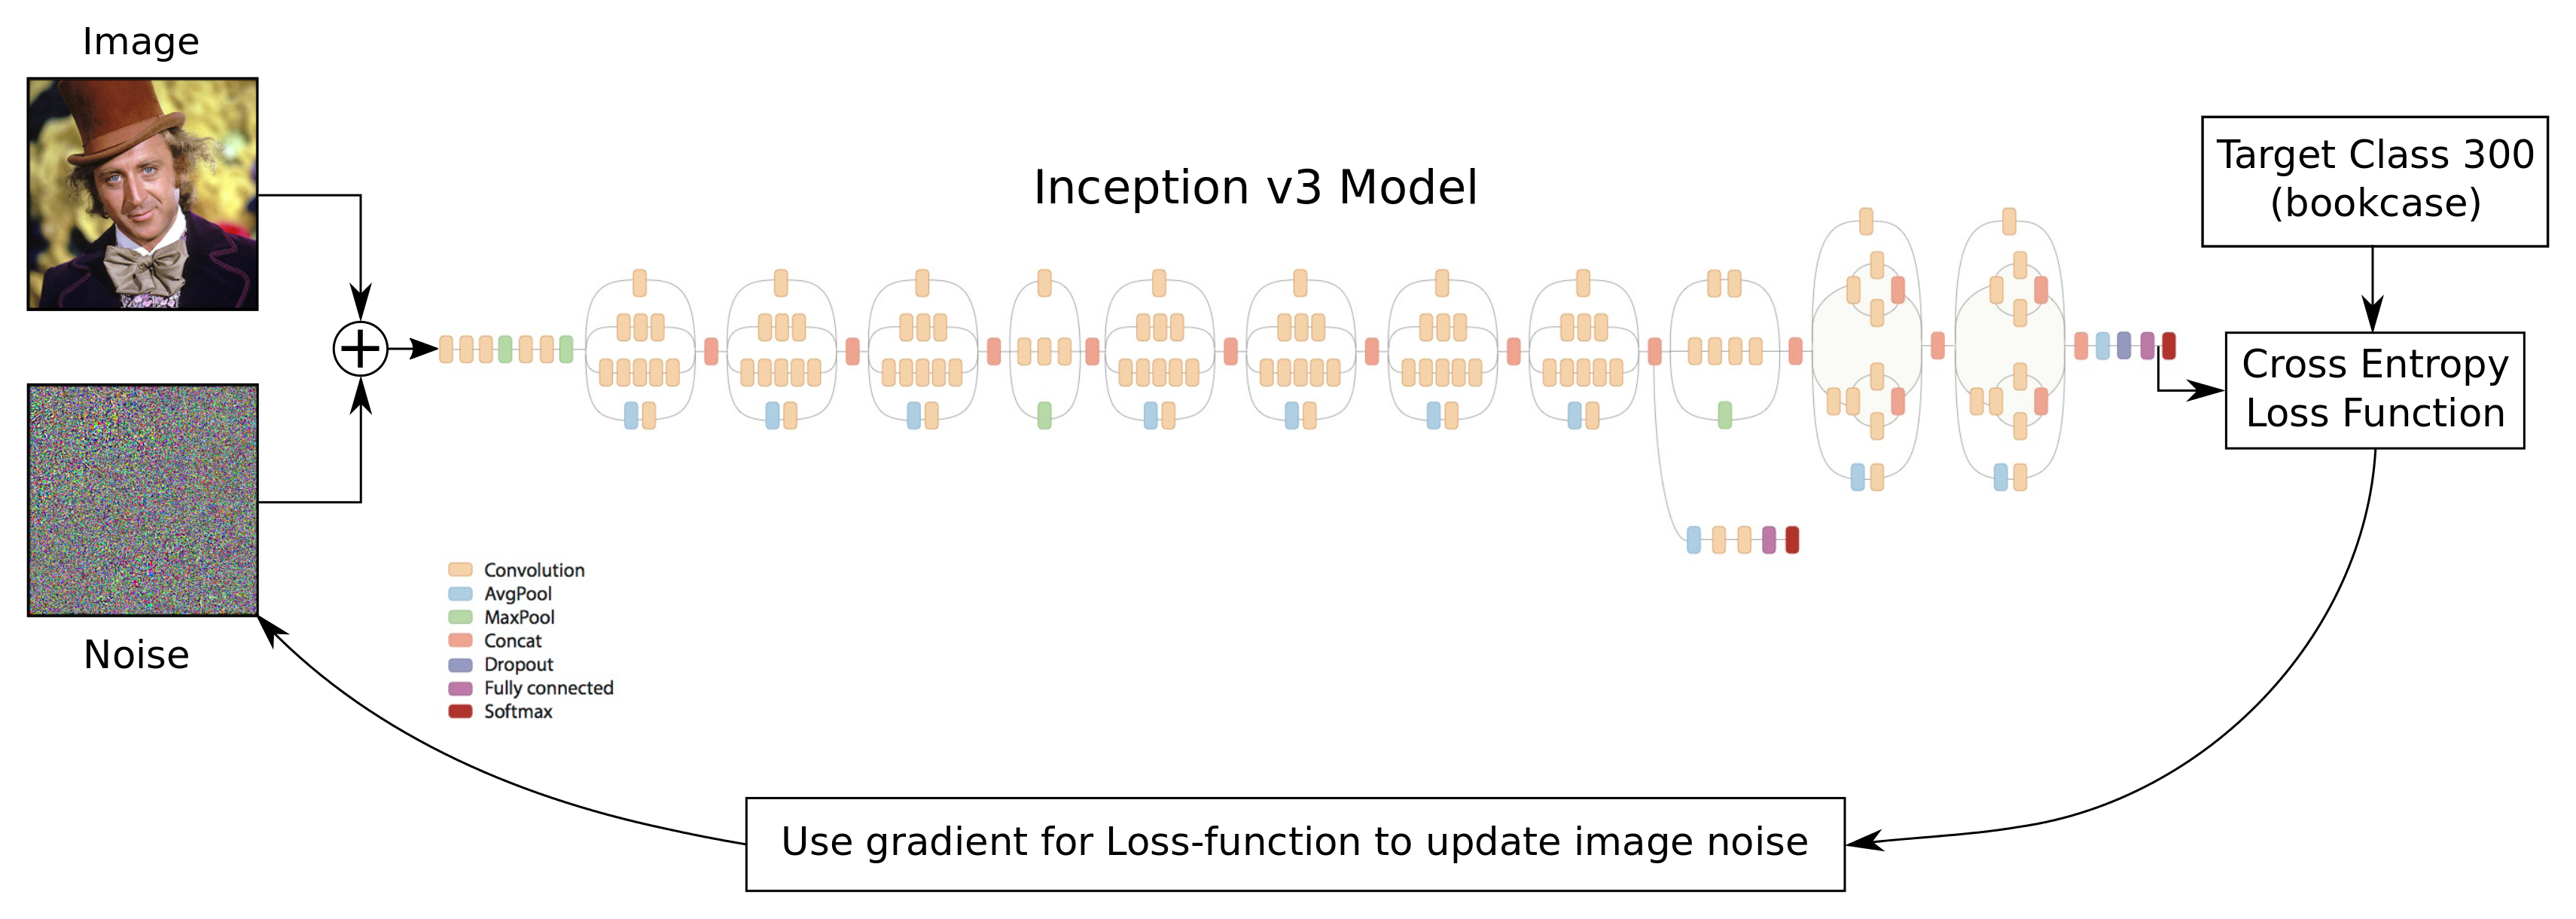

In [1]:
from IPython.display import Image, display
Image("D:\\jupyter\\tensorflow_tutorial\images\\11_adversarial_examples_flowchart.png")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

#Function and classes for loading and using the Inception model
import inception

c:\deeplearning\python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
inception.data_dir = "D:\jupyter\\tensorflow_tutorial\CH11_Adversarial_Examples\inception"

In [4]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


In [5]:
model = inception.Inception()

In [6]:
resized_image = model.resized_image

In [7]:
y_pred = model.y_pred

In [8]:
y_logits = model.y_logits

In [11]:
#Set the graph for the Inception model as the default，
#so that all changes inside this with-block are done to that graph.
with model.graph.as_default():
    #Add a placeholder variable for the target class-number.
    #This will be set to e.g. 300 for the 'bookcase' class.
    pl_cls_target = tf.placeholder(dtype=tf.int32)
    
    #Add a new loss-function, This is the cross-entropy.
    #See Tutorial #01 for an explanation of cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits, labels=[pl_cls_target])
    
    #Get the gradient for the loss-function with regard to
    #the resized input image.
    gradient = tf.gradients(loss, resized_image)

##  TensorFlow Session 

In [13]:
session = tf.Session(graph=model.graph)

##  Helper-function for finding Adversary Noise

In [15]:
def find_adversary_noise(image_path, cls_target, noise_limit=3.0,
                         required_score=0.99, max_iterations=100):
    """
    Find the noise that must be added to the given image so
    that it is classified as the target-class.
    
    image_path: File-path to the input-image (must be *.jpg).
    cls_target: Target class-number (integer between 1-1000).
    noise_limit: Limit for pixel-values in the noise.
    required_score: Stop when target-class score reaches this.
    max_iterations: Max number of optimization iterations to perform.
    """

    # Create a feed-dict with the image.
    feed_dict = model._create_feed_dict(image_path=image_path)

    # Use TensorFlow to calculate the predicted class-scores
    # (aka. probabilities) as well as the resized image.
    pred, image = session.run([y_pred, resized_image],
                              feed_dict=feed_dict)

    # Convert to one-dimensional array.
    pred = np.squeeze(pred)

    # Predicted class-number.
    cls_source = np.argmax(pred)

    # Score for the predicted class (aka. probability or confidence).
    score_source_org = pred.max()

    # Names for the source and target classes.
    name_source = model.name_lookup.cls_to_name(cls_source,
                                                only_first_name=True)
    name_target = model.name_lookup.cls_to_name(cls_target,
                                                only_first_name=True)

    # Initialize the noise to zero.
    noise = 0

    # Perform a number of optimization iterations to find
    # the noise that causes mis-classification of the input image.
    for i in range(max_iterations):
        print("Iteration:", i)

        # The noisy image is just the sum of the input image and noise.
        noisy_image = image + noise

        # Ensure the pixel-values of the noisy image are between
        # 0 and 255 like a real image. If we allowed pixel-values
        # outside this range then maybe the mis-classification would
        # be due to this 'illegal' input breaking the Inception model.
        noisy_image = np.clip(a=noisy_image, a_min=0.0, a_max=255.0)

        # Create a feed-dict. This feeds the noisy image to the
        # tensor in the graph that holds the resized image, because
        # this is the final stage for inputting raw image data.
        # This also feeds the target class-number that we desire.
        feed_dict = {model.tensor_name_resized_image: noisy_image,
                     pl_cls_target: cls_target}

        # Calculate the predicted class-scores as well as the gradient.
        pred, grad = session.run([y_pred, gradient],
                                 feed_dict=feed_dict)

        # Convert the predicted class-scores to a one-dim array.
        pred = np.squeeze(pred)

        # The scores (probabilities) for the source and target classes.
        score_source = pred[cls_source]
        score_target = pred[cls_target]

        # Squeeze the dimensionality for the gradient-array.
        grad = np.array(grad).squeeze()

        # The gradient now tells us how much we need to change the
        # noisy input image in order to move the predicted class
        # closer to the desired target-class.

        # Calculate the max of the absolute gradient values.
        # This is used to calculate the step-size.
        grad_absmax = np.abs(grad).max()
        
        # If the gradient is very small then use a lower limit,
        # because we will use it as a divisor.
        if grad_absmax < 1e-10:
            grad_absmax = 1e-10

        # Calculate the step-size for updating the image-noise.
        # This ensures that at least one pixel colour is changed by 7.
        # Recall that pixel colours can have 255 different values.
        # This step-size was found to give fast convergence.
        step_size = 7 / grad_absmax

        # Print the score etc. for the source-class.
        msg = "Source score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_source, cls_source, name_source))

        # Print the score etc. for the target-class.
        msg = "Target score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_target, cls_target, name_target))

        # Print statistics for the gradient.
        msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
        print(msg.format(grad.min(), grad.max(), step_size))

        # Newline.
        print()

        # If the score for the target-class is not high enough.
        if score_target < required_score:
            # Update the image-noise by subtracting the gradient
            # scaled by the step-size.
            noise -= step_size * grad

            # Ensure the noise is within the desired range.
            # This avoids distorting the image too much.
            noise = np.clip(a=noise,
                            a_min=-noise_limit,
                            a_max=noise_limit)
        else:
            # Abort the optimization because the score is high enough.
            break

    return image.squeeze(), noisy_image.squeeze(), noise, \
           name_source, name_target, \
           score_source, score_source_org, score_target

####   Helper-function for plotting image and noise

In [16]:
def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm

In [17]:
def plot_images(image, noise, noisy_image,
                name_source, name_target,
                score_source, score_source_org, score_target):
    """
    Plot the image, the noisy image and the noise.
    Also shows the class-names and scores.

    Note that the noise is amplified to use the full range of
    colours, otherwise if the noise is very low it would be
    hard to see.

    image: Original input image.
    noise: Noise that has been added to the image.
    noisy_image: Input image + noise.
    name_source: Name of the source-class.
    name_target: Name of the target-class.
    score_source: Score for the source-class.
    score_source_org: Original score for the source-class.
    score_target: Score for the target-class.
    """
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10,10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # Plot the original image.
    # Note that the pixel-values are normalized to the [0.0, 1.0]
    # range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(image / 255.0, interpolation=interpolation)
    msg = "Original Image:\n{0} ({1:.2%})"
    xlabel = msg.format(name_source, score_source_org)
    ax.set_xlabel(xlabel)

    # Plot the noisy image.
    ax = axes.flat[1]
    ax.imshow(noisy_image / 255.0, interpolation=interpolation)
    msg = "Image + Noise:\n{0} ({1:.2%})\n{2} ({3:.2%})"
    xlabel = msg.format(name_source, score_source, name_target, score_target)
    ax.set_xlabel(xlabel)

    # Plot the noise.
    # The colours are amplified otherwise they would be hard to see.
    ax = axes.flat[2]
    ax.imshow(normalize_image(noise), interpolation=interpolation)
    xlabel = "Amplified Noise"
    ax.set_xlabel(xlabel)

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for finding and plotting adversarial example

In [18]:
def adversary_example(image_path, cls_target,
                      noise_limit, required_score):
    """
    Find and plot adversarial noise for the given image.
    
    image_path: File-path to the input-image (must be *.jpg).
    cls_target: Target class-number (integer between 1-1000).
    noise_limit: Limit for pixel-values in the noise.
    required_score: Stop when target-class score reaches this.
    """

    # Find the adversarial noise.
    image, noisy_image, noise, \
    name_source, name_target, \
    score_source, score_source_org, score_target = \
        find_adversary_noise(image_path=image_path,
                             cls_target=cls_target,
                             noise_limit=noise_limit,
                             required_score=required_score)

    # Plot the image and the noise.
    plot_images(image=image, noise=noise, noisy_image=noisy_image,
                name_source=name_source, name_target=name_target,
                score_source=score_source,
                score_source_org=score_source_org,
                score_target=score_target)

    # Print some statistics for the noise.
    msg = "Noise min: {0:.3f}, max: {1:.3f}, mean: {2:.3f}, std: {3:.3f}"
    print(msg.format(noise.min(), noise.max(),
                     noise.mean(), noise.std()))

Iteration: 0
Source score:  97.52%, class-number:  409, class-name: macaw
Target score:   0.00%, class-number:  300, class-name: bookcase
Gradient min: -0.001650, max:  0.001396, stepsize:   4242.15

Iteration: 1
Source score:  86.03%, class-number:  409, class-name: macaw
Target score:   0.02%, class-number:  300, class-name: bookcase
Gradient min: -0.001716, max:  0.002322, stepsize:   3014.81

Iteration: 2
Source score:  68.33%, class-number:  409, class-name: macaw
Target score:   0.06%, class-number:  300, class-name: bookcase
Gradient min: -0.001808, max:  0.001604, stepsize:   3871.68

Iteration: 3
Source score:  23.38%, class-number:  409, class-name: macaw
Target score:   0.16%, class-number:  300, class-name: bookcase
Gradient min: -0.001359, max:  0.000997, stepsize:   5152.32

Iteration: 4
Source score:  18.39%, class-number:  409, class-name: macaw
Target score:   0.39%, class-number:  300, class-name: bookcase
Gradient min: -0.001334, max:  0.001029, stepsize:   5248.19



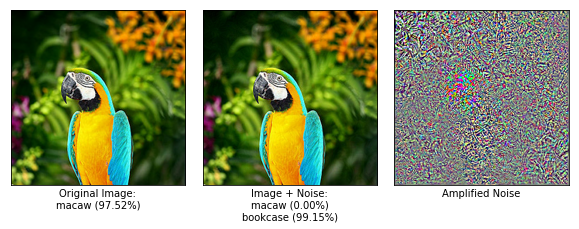

Noise min: -3.000, max: 3.000, mean: -0.001, std: 1.456


In [19]:
image_path = "D:\\jupyter\\tensorflow_tutorial\\images\\parrot_cropped1.jpg"

adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

####  Elon musk

Iteration: 0
Source score:  16.63%, class-number:  837, class-name: sweatshirt
Target score:   0.01%, class-number:  300, class-name: bookcase
Gradient min: -0.003983, max:  0.005454, stepsize:   1283.43

Iteration: 1
Source score:   2.20%, class-number:  837, class-name: sweatshirt
Target score:   0.31%, class-number:  300, class-name: bookcase
Gradient min: -0.006165, max:  0.006373, stepsize:   1098.31

Iteration: 2
Source score:   0.84%, class-number:  837, class-name: sweatshirt
Target score:   8.83%, class-number:  300, class-name: bookcase
Gradient min: -0.005487, max:  0.004381, stepsize:   1275.76

Iteration: 3
Source score:   0.25%, class-number:  837, class-name: sweatshirt
Target score:  72.22%, class-number:  300, class-name: bookcase
Gradient min: -0.000869, max:  0.001108, stepsize:   6318.90

Iteration: 4
Source score:   0.02%, class-number:  837, class-name: sweatshirt
Target score:  62.94%, class-number:  300, class-name: bookcase
Gradient min: -0.002786, max:  0.0029

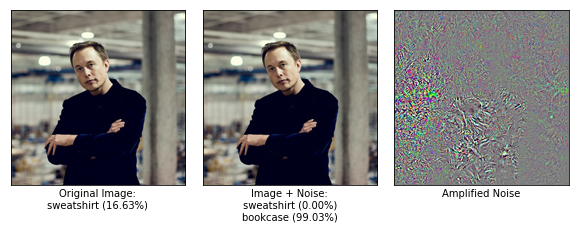

Noise min: -3.000, max: 3.000, mean: -0.000, std: 0.740


In [21]:
image_path = "D:\\jupyter\\tensorflow_tutorial\\images\\elon_musk.jpg"

adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

Iteration: 0
Source score:  34.47%, class-number:  535, class-name: sunglasses
Target score:   0.03%, class-number:  300, class-name: bookcase
Gradient min: -0.002034, max:  0.002554, stepsize:   2740.36

Iteration: 1
Source score:   2.12%, class-number:  535, class-name: sunglasses
Target score:   0.13%, class-number:  300, class-name: bookcase
Gradient min: -0.000921, max:  0.000930, stepsize:   7529.45

Iteration: 2
Source score:  11.12%, class-number:  535, class-name: sunglasses
Target score:   0.32%, class-number:  300, class-name: bookcase
Gradient min: -0.001795, max:  0.001717, stepsize:   3898.93

Iteration: 3
Source score:   2.51%, class-number:  535, class-name: sunglasses
Target score:   0.73%, class-number:  300, class-name: bookcase
Gradient min: -0.002325, max:  0.002158, stepsize:   3011.34

Iteration: 4
Source score:   4.83%, class-number:  535, class-name: sunglasses
Target score:   1.53%, class-number:  300, class-name: bookcase
Gradient min: -0.001309, max:  0.0011

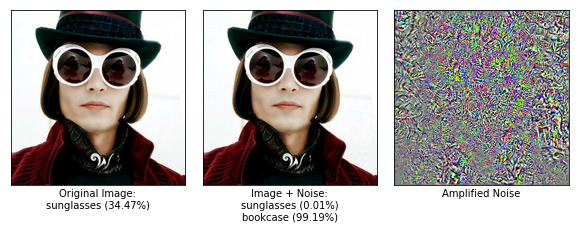

Noise min: -3.000, max: 3.000, mean: 0.009, std: 1.479


In [22]:
image_path = "D:\\jupyter\\tensorflow_tutorial\\images\\willy_wonka_new.jpg"

adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

Iteration: 0
Source score:  97.98%, class-number:  817, class-name: bow tie
Target score:   0.00%, class-number:  300, class-name: bookcase
Gradient min: -0.002918, max:  0.002894, stepsize:   2398.53

Iteration: 1
Source score:  12.07%, class-number:  817, class-name: bow tie
Target score:   0.08%, class-number:  300, class-name: bookcase
Gradient min: -0.000892, max:  0.001308, stepsize:   5350.91

Iteration: 2
Source score:   1.29%, class-number:  817, class-name: bow tie
Target score:   0.29%, class-number:  300, class-name: bookcase
Gradient min: -0.000738, max:  0.000531, stepsize:   9480.40

Iteration: 3
Source score:   8.06%, class-number:  817, class-name: bow tie
Target score:   0.68%, class-number:  300, class-name: bookcase
Gradient min: -0.000587, max:  0.000721, stepsize:   9710.89

Iteration: 4
Source score:   0.78%, class-number:  817, class-name: bow tie
Target score:   0.95%, class-number:  300, class-name: bookcase
Gradient min: -0.001124, max:  0.001012, stepsize:  

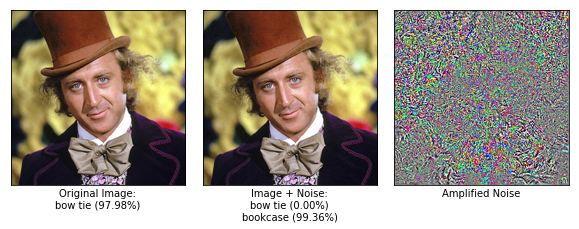

Noise min: -3.000, max: 3.000, mean: 0.001, std: 1.401


In [23]:
image_path = "D:\\jupyter\\tensorflow_tutorial\\images\\willy_wonka_old.jpg"

adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

##  Close Tensorflow Session

In [25]:
session.close()
model.close()